In [6]:
import numpy as np 
import pandas as pd 
import datetime
import math
from collections import defaultdict
import itertools
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt 
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV, ElasticNet
# from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error,make_scorer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import make_column_selector as selector

#Configurations
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


> 

In [7]:
train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

holidays_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
submission_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
submission_data.rename(columns = {'id':'id', 'sales':'submission_d'}, inplace = True )
stores_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

holidays_data['date'] = pd.to_datetime(holidays_data['date'], format = "%Y-%m-%d")
oil_data['date'] = pd.to_datetime(oil_data['date'], format = "%Y-%m-%d")
transactions_data['date'] = pd.to_datetime(transactions_data['date'], format = "%Y-%m-%d")
train_data['date'] = pd.to_datetime(train_data['date'], format = "%Y-%m-%d")
test_data['date'] = pd.to_datetime(test_data['date'], format = "%Y-%m-%d")

In [8]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [9]:
train_data_start = train_data.date.min().date()
train_data_end = train_data.date.max().date()

missing_dates = pd.date_range(train_data_start, train_data_end
                             ).difference(train_data.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

missing_dates

['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']

In [10]:
# reindex training data
multi_idx = pd.MultiIndex.from_product([pd.date_range(train_data_start, train_data_end), 
                                        train_data.store_nbr.unique(), 
                                        train_data.family.unique()],
                                        names=["date", "store_nbr", "family"],)
train_data = train_data.set_index(["date", "store_nbr", "family"]
                                 ).reindex(multi_idx).reset_index()
# fill missing values with 0s
train_data[["sales", "onpromotion"]] = train_data[["sales", "onpromotion"]].fillna(0.)
# interpolate  for the 'id'
train_data.id = train_data.id.interpolate(method="linear")

train_data

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00
1,2013-01-01,1,BABY CARE,1.00,0.00,0.00
2,2013-01-01,1,BEAUTY,2.00,0.00,0.00
3,2013-01-01,1,BEVERAGES,3.00,0.00,0.00
4,2013-01-01,1,BOOKS,4.00,0.00,0.00
...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.00,438.13,0.00
3008012,2017-08-15,9,PREPARED FOODS,3000884.00,154.55,1.00
3008013,2017-08-15,9,PRODUCE,3000885.00,2419.73,148.00
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.00,121.00,8.00


Here we can see test_data:

In [11]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [12]:
test_data_start = test_data.date.min().date()
test_data_end = test_data.date.max().date()

missing_dates_test = pd.date_range(test_data_start, test_data_end
                             ).difference(test_data.date.unique())
missing_dates_test = missing_dates_test.strftime("%Y-%m-%d").tolist()

missing_dates_test

[]

How we can notice there are no gaps in the test data.


In [13]:
#let's add an additional column that will help us separate test and training data in the future
test_data['test'] = 1
train_data['test'] = 0

In [14]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [16]:
# reindex oil data
oil_data = oil_data.merge(pd.DataFrame({"date": pd.date_range(train_data_start, 
                                                              test_data_end)}),
                          on="date",how="outer",).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil_data.dcoilwtico = oil_data.dcoilwtico.interpolate(method="linear", limit_direction="both")


In [17]:
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Fill in the missing values ​​for transactions using interpolation, except for days with zero sales

In [18]:
num_store = train_data.store_nbr.nunique()
train_len = (train_data_end - train_data_start).days + 1

num_zero_sales = (train_data.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transactions_data.index)
missing_rec = total_rec - curr_rec - num_zero_sales

#total sales for each store
store_sales = train_data.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transactions_data = transactions_data.merge(
    store_sales, on=["date", "store_nbr"],how="outer").sort_values(
    ["date", "store_nbr"],ignore_index=True)

# fill missing values with 0s for days with zero sales
transactions_data.loc[transactions_data.sales.eq(0), "transactions"] = 0
transactions_data = transactions_data.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transactions_data.transactions = transactions_data.groupby(
    "store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both"))

In [19]:
#Here we can see holidays_data:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


As we can see the most popular types are Holiday,National,Ecuador

In [21]:
print('Holidays types:', holidays_data['type'].unique())
print('Holidays region types:', holidays_data['locale'].unique()) 
print('Holidays locale names:', holidays_data['locale_name'].unique())  

national_locale_name = sorted(holidays_data[holidays_data['locale']=="National"
                                           ]['locale_name'].unique().tolist())
regional_locale_name = sorted(holidays_data[holidays_data['locale']=="Regional"
                                           ]['locale_name'].unique().tolist())
local_locale_name = sorted(holidays_data[holidays_data['locale']=="Local"
                                        ]['locale_name'].unique().tolist())

print(f'Locale names for national holidays:{national_locale_name}')
print(f'Locale names for regional holidays:{regional_locale_name}')
print(f'Locale names for local holidays:{local_locale_name}')

Holidays types: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holidays region types: ['Local' 'Regional' 'National']
Holidays locale names: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
Locale names for national holidays:['Ecuador']
Locale names for regional holidays:['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']
Locale names for local holidays:['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [22]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(stores_data['city'].str.lower()) | set(stores_data['state'].str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

holidays_data['description'] = holidays_data.apply(
    lambda x: x['description'].lower().replace(x['locale_name'].lower(), ""), 
    axis=1,).apply(process_holiday).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,).replace(
    r"\s+|-", " ", regex=True,).str.strip()

# remove transferred holidays
holidays_data = holidays_data[holidays_data['transferred'].eq(False)]

#Saturdays designated as work days 
work_days = holidays_data[holidays_data['type'].eq("Work Day")]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}
                                              ).reset_index(drop=True)
work_days['work_day'] = work_days['work_day'].notna().astype(int)

# remove work days after extracting above
holidays_data = holidays_data[holidays_data['type']!="Work Day"].reset_index(drop=True)
holidays_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False
...,...,...,...,...,...,...
328,2017-12-22,Additional,National,Ecuador,navidad,False
329,2017-12-23,Additional,National,Ecuador,navidad,False
330,2017-12-24,Additional,National,Ecuador,navidad,False
331,2017-12-25,Holiday,National,Ecuador,navidad,False


In [23]:
#local holidays (city level) 
local_holidays = holidays_data[holidays_data['locale'].eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}).reset_index(drop=True)

local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

local_holidays.head()

,date,city,loc_cantonizacion,loc_fundacion,loc_independencia
0,2012-03-02,Manta,0,1,0
1,2012-04-12,Cuenca,0,1,0
2,2012-04-14,Libertad,1,0,0
3,2012-04-21,Riobamba,1,0,0
4,2012-05-12,Puyo,1,0,0


In [24]:
#regional holidays 
regional_holidays = holidays_data[holidays_data['locale'].eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}).reset_index(drop=True)
regional_holidays['provincializacion'] = regional_holidays['provincializacion'].eq(
    "provincializacion").astype(int)

regional_holidays

,date,state,provincializacion
0,2012-04-01,Cotopaxi,1
1,2012-06-25,Imbabura,1
2,2012-11-06,Santo Domingo de los Tsachilas,1
3,2012-11-07,Santa Elena,1
4,2013-04-01,Cotopaxi,1
5,2013-06-25,Imbabura,1
6,2013-11-06,Santo Domingo de los Tsachilas,1
7,2013-11-07,Santa Elena,1
8,2014-04-01,Cotopaxi,1
9,2014-06-25,Imbabura,1


In [25]:
#national holidays 
national_holidays = holidays_data[holidays_data['locale'].eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={
    "nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [26]:
sales_ts = pd.pivot_table(train_data, values="sales", index="date", 
                          columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transactions_data, values="transactions", index="date", 
                       columns="store_nbr")
promo_ts = pd.pivot_table(train_data, values="onpromotion", index="date", 
                          columns=["store_nbr", "family"])

Here we can see stores_data:

In [27]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [28]:
# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,).reset_index().merge(
    stores_data, on="store_nbr", how="left").merge(
    work_days, on="date", how="left").merge(
    local_holidays, on=["date", "city"], how="left").merge(
    regional_holidays, on=["date", "state"], how="left").merge(
    national_holidays, on="date", how="left").fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith((
    "loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(
    axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,loc_fundacion,loc_independencia,provincializacion,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0
1,2013-01-02,1,AUTOMOTIVE,0.11,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
2,2013-01-03,1,AUTOMOTIVE,0.16,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3,2013-01-04,1,AUTOMOTIVE,0.16,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
4,2013-01-05,1,AUTOMOTIVE,0.26,Quito,Pichincha,D,13,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [30]:
# keep selected national holidays with larger impacts on sales
selected_holidays = ["nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos"]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

data = pd.concat(
    [train_data, test_data], axis=0, ignore_index=True,
).merge(
    stores_data, on=["store_nbr"]
).merge(
    oil_data, on=["date"], how="left"
).merge(
    transactions_data, on=["date", 'store_nbr'], how="left"
).merge(
    work_days, on="date", how="left",    
).merge(
    keep_national_holidays, on=["date"],how="left").sort_values(["date", "store_nbr", "family"], ignore_index=True)

data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

In [31]:
## Select the date, days of the week, hours, month  !not used in calculations
data['day_of_week'] = data.date.dt.dayofweek
data['day_of_year'] = data.date.dt.dayofyear
data['day_of_month'] = data.date.dt.day
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
#seasons 0-winter;1-spring;2-summer;3-fall
data["season"] = np.where(data.date.dt.month.isin([12,1,2]), 0, 1)
data["season"] = np.where(data.date.dt.month.isin([3,4,5]), 1, data["season"])
data["season"] = np.where(data.date.dt.month.isin([6,7,8]), 2, data["season"])
data["season"] = np.where(data.date.dt.month.isin([9, 10, 11]), 3, data["season"])
data.head()

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,day_of_week,day_of_year,day_of_month,year,month,season
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
1,2013-01-01,1,BABY CARE,1.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
2,2013-01-01,1,BEAUTY,2.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
3,2013-01-01,1,BEVERAGES,3.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
4,2013-01-01,1,BOOKS,4.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0


In [33]:
#Let's keep data for 1-20 stores, due to the lack of memory
data = data.loc[data['store_nbr'].isin(list(range(1, 19)))]

In [34]:
train = data.loc[data['test'] == 0]
test = data.loc[data['test'] == 1]

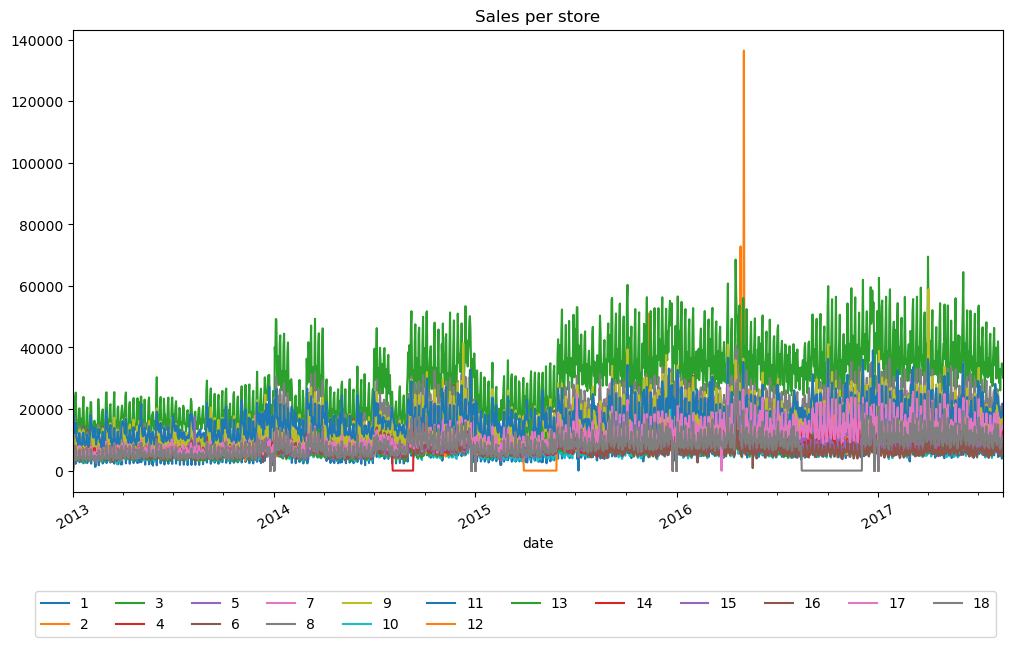

In [36]:
sale_store = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
sale_store = sale_store.pivot(index='date', columns='store_nbr', values='sales')
sale_store.plot(figsize=(12, 6))
plt.title("Sales per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12)
plt.show()

on the chart we can observe a point with abnormal sales in 2016 for the certain stores

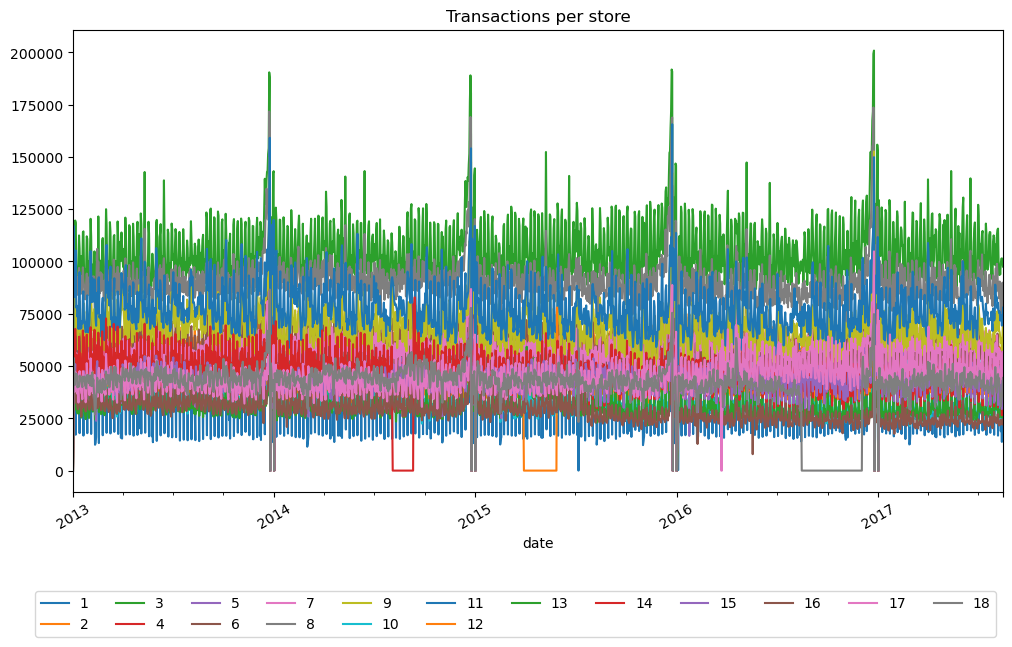

In [37]:
tr_store = train.groupby(['date','store_nbr'], as_index=False)['transactions'].sum()
tr_store = tr_store.pivot(index='date', columns='store_nbr', values='transactions')
tr_store.plot(figsize=(12, 6))
plt.title("Transactions per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12) 
plt.show()

no anomalies are observed on the chart with transactions

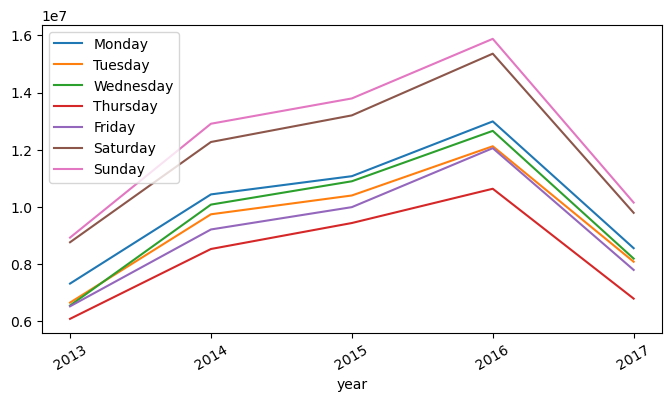

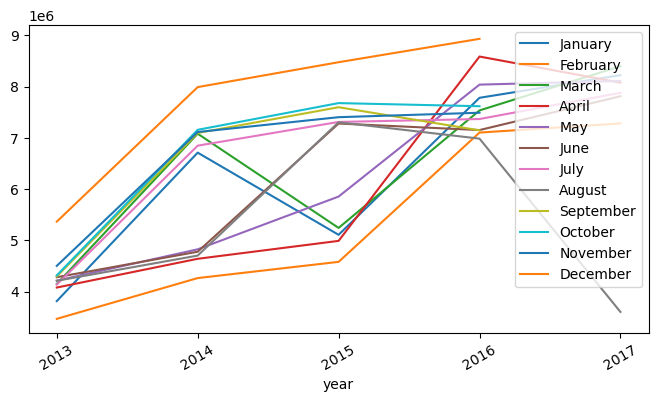

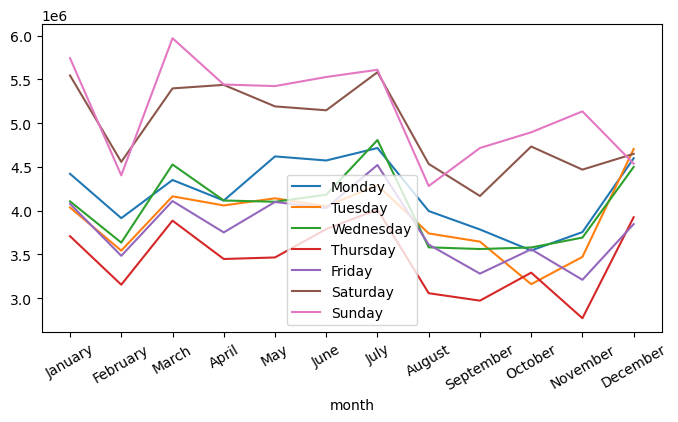

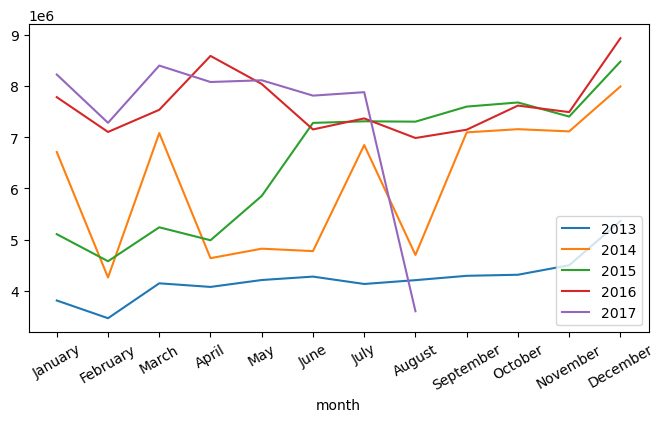

In [39]:
list_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
list_months = ['January','February','March','April','May','June','July','August','September','October','November','December'] 
list_years = ['2013','2014','2015','2016','2017']

frame1 = train.groupby(['day_of_week', 'year'], as_index=False)['sales'].sum()
frame1 = frame1.pivot(index='year', columns='day_of_week', values='sales')
frame1.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_days)

frame4 = train.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame4 = frame4.pivot(index='year', columns='month', values='sales')
frame4.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_months)

frame2 = train.groupby(['day_of_week', 'month'], as_index=False)['sales'].sum()
frame2 = frame2.pivot(index='month', columns='day_of_week', values='sales')
frame2.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months,rotation=30)
plt.legend(list_days)

frame3 = train.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame3 = frame3.pivot(index='month', columns='year', values='sales')
frame3.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months, rotation=30)
plt.legend(list_years)


plt.show()

As we can see, for many categories of goods, demand increases depending on whether it participates in promotions

we can notice that the more expensive oil is, the fewer sales

you can see that the number of sales increases with the number of transactions, which is quite expected

we can notice that the dependence of different types of goods on oil varies greatly, which means this is an important feature

In [44]:
data_seasons = train.copy()
data_winter = data_seasons[data_seasons['season']==0]
data_spring = data_seasons[data_seasons['season']==1]
data_summer = data_seasons[data_seasons['season']==2]
data_fall = data_seasons[data_seasons['season']==3]

sales_family_winter = data_winter.groupby(['family'])['sales'].sum().reset_index()
sales_family_spring = data_spring.groupby(['family'])['sales'].sum().reset_index()
sales_family_summer = data_summer.groupby(['family'])['sales'].sum().reset_index()
sales_family_fall = data_fall.groupby(['family'])['sales'].sum().reset_index()

sales_family_winter = sales_family_winter.rename(columns = {"sales": "sales_winter"})
sales_family_spring = sales_family_spring.rename(columns = {"sales": "sales_spring"})
sales_family_summer = sales_family_summer.rename(columns = {"sales": "sales_summer"})
sales_family_fall = sales_family_fall.rename(columns = {"sales": "sales_fall"})

df_all_seasons = sales_family_winter.merge(
    sales_family_spring, on=["family"]).merge(
    sales_family_summer, on=["family"]).merge(
    sales_family_fall, on=["family"])

df_all_seasons.head()

,family,sales_winter,sales_spring,sales_summer,sales_fall
0,AUTOMOTIVE,41574.00,45796.00,43230.00,34774.00
1,BABY CARE,1001.00,1114.00,1489.00,1060.00
2,BEAUTY,26919.00,27728.00,29905.00,23689.00
3,BEVERAGES,17366197.00,18216018.00,18207011.00,16561615.00
4,BOOKS,771.00,291.00,41.00,987.00


In [47]:
del data_sales_prom,df_all_seasons,sales_family_winter,sales_family_spring,sales_family_summer,sales_family_fall,data_winter,data_spring,data_summer,data_fall

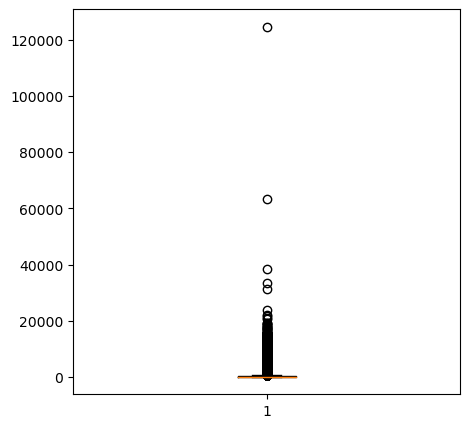

In [50]:
fig = plt.figure()
fig.set_size_inches((5, 5))
plt.boxplot(train['sales'].values)

plt.show()

we may notice that there are outliers in the data, but we deliberately exclude them

**heatmap with correlation matrix**

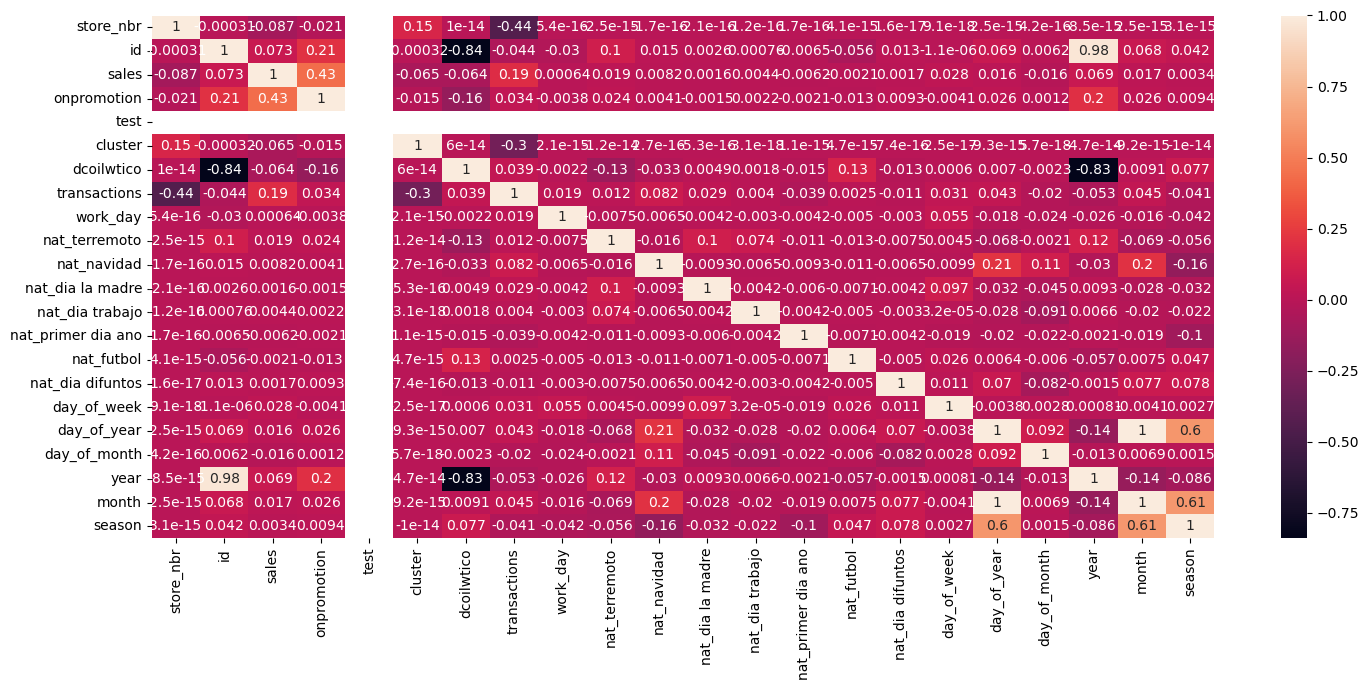

In [51]:
plt.figure(figsize=(15,7))
sns.heatmap(train.corr(),annot=True)
plt.tight_layout()

We can notice that the signs are weakly correlated

In [52]:
data_analyses = data.copy()

target = 'sales'
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

In [53]:
def CompareTwoGroups(dataframe, group, target):
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], 
                             "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], 
                             "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], 
                             "GroupB_Count":[groupB.count()]}, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, 
                                              "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", 
                                  "p-value","GroupA_Median", "GroupB_Median",
                                  "GroupA_Mean", "GroupB_Mean",
                                  "GroupA_Count", "GroupB_Count"]]])   
    return AB

CompareTwoGroups(train, group = "store_nbr", target = "sales")

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 2)",Non-Parametric,Different Groups,0.00,18.55,23.00,253.93,387.00,55704,55704
"(1, 3)",Non-Parametric,Different Groups,0.00,18.55,63.00,253.93,906.25,55704,55704
"(1, 4)",Non-Parametric,Different Groups,0.00,18.55,19.00,253.93,339.47,55704,55704
"(1, 5)",Non-Parametric,Different Groups,0.00,18.55,19.00,253.93,279.92,55704,55704
"(1, 6)",Non-Parametric,Different Groups,0.00,18.55,28.00,253.93,452.10,55704,55704
...,...,...,...,...,...,...,...,...,...
"(15, 17)",Non-Parametric,Different Groups,0.00,8.00,10.00,205.57,323.69,55704,55704
"(15, 18)",Non-Parametric,Similar Groups,0.39,8.00,8.00,205.57,238.03,55704,55704
"(16, 17)",Non-Parametric,Different Groups,0.00,6.00,10.00,197.23,323.69,55704,55704
"(16, 18)",Non-Parametric,Different Groups,0.00,6.00,8.00,197.23,238.03,55704,55704


In [54]:
# Rolling Summary Stats Features
#A rolling mean is simply the mean of a certain number of previous periods in a time series.
for i in [16,17,18,19,20,21,22,46,76,106,365, 730]:
    data_analyses["sales_roll_mean_"+str(i)]=data_analyses.groupby(
        ["store_nbr", "family"])['sales'].rolling(i).mean().shift(1).values
    
# 2. Hypothesis Testing: Similarity
# Store Based
storesales = train.groupby(["date", "store_nbr"])['sales'].sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store_nbr", target="sales")
del storesales
#Let's find similar groups
ctg_ss[ctg_ss["Compare Two Groups"] == "Similar Groups"]

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(12, 16)",Non-Parametric,Similar Groups,0.61,6386.87,6146.28,6314.70,6508.54,1688,1688
"(14, 15)",Non-Parametric,Similar Groups,0.16,6529.03,6826.27,6746.40,6783.93,1688,1688


As we can see, there were two pairs of similar stores (12,16) and (14,15) and we can create a special feature reflecting the similarity of the stores

In [55]:
data_analyses["StoreSalesSimilarity"] = np.where(data_analyses["store_nbr"].isin([12,16]), 1, 0)
data_analyses["StoreSalesSimilarity"] = np.where(data_analyses["store_nbr"].isin([14,15]), 2, data_analyses["StoreSalesSimilarity"])

#Now let's filter the results by similarity of groups when grouped by "family"
# Item Based
itemsales = train.groupby(["date", "family"])['sales'].sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "family", target = "sales")
del itemsales
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(CELEBRATION, LINGERIE)",Non-Parametric,Similar Groups,0.15,184.00,157.00,156.99,161.87,1688,1688
"(GROCERY II, HOME AND KITCHEN I)",Non-Parametric,Similar Groups,0.87,359.00,376.00,379.52,339.36,1688,1688
"(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)",Non-Parametric,Similar Groups,0.05,8.00,7.00,8.09,19.18,1688,1688
"(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)",Non-Parametric,Similar Groups,0.26,82.00,127.00,104.91,103.80,1688,1688
"(MAGAZINES, PET SUPPLIES)",Non-Parametric,Similar Groups,0.69,26.50,66.00,54.12,55.95,1688,1688


As we can see, there were two pairs of similar family (CELEBRATION, LINGERIE),(GROCERY II, HOME AND KITCHEN I), (HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES), (LAWN AND GARDEN, PLAYERS AND ELECTRONICS), (MAGAZINES, PET SUPPLIES) and we can create a special feature reflecting the similarity of the family

In [56]:
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['CELEBRATION', 'LINGERIE']), 1, 0)
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['GROCERY II', 'HOME AND KITCHEN I']), 2, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['HOME APPLIANCES', 'SCHOOL AND OFFICE SUPPLIES']), 3, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS']), 4, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['MAGAZINES', 'PET SUPPLIES']), 5, data_analyses["ItemSalesSimilarity"])

In [57]:
data_analyses.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)

In [58]:
def lag_features(dataframe, lags, groups = ["store_nbr", "family"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

#Let's create lags
data_analyses = lag_features(data_analyses, 
                             lags = [16,17,18,19,20,21,22,46,76,106,365, 730],
                             groups = ["store_nbr", "family"], target = 'sales', 
                             prefix = 'sales_lag_')
data_analyses

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,day_of_week,day_of_year,day_of_month,year,month,season,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_19,sales_roll_mean_20,sales_roll_mean_21,sales_roll_mean_22,sales_roll_mean_46,sales_roll_mean_76,sales_roll_mean_106,sales_roll_mean_365,sales_roll_mean_730,StoreSalesSimilarity,ItemSalesSimilarity,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_46,sales_lag_76,sales_lag_106,sales_lag_365,sales_lag_730
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,2013-01-02,1,AUTOMOTIVE,1782.00,2.00,0.00,0,Quito,Pichincha,D,13,93.14,2111.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,2,2,2013,1,0,1.56,1.65,1.94,1.89,2.05,2.05,1.95,2.89,2.62,2.44,2.38,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3564,2013-01-03,1,AUTOMOTIVE,3564.00,3.00,0.00,0,Quito,Pichincha,D,13,92.97,1833.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,3,3,2013,1,0,5.06,4.94,4.89,5.11,5.25,5.14,5.36,5.37,4.88,4.84,3.69,3.22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5346,2013-01-04,1,AUTOMOTIVE,5346.00,3.00,0.00,0,Quito,Pichincha,D,13,93.12,1863.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,4,4,2013,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7128,2013-01-05,1,AUTOMOTIVE,7128.00,5.00,0.00,0,Quito,Pichincha,D,13,93.15,1509.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,5,5,2013,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028211,2017-08-27,18,SEAFOOD,3020819.00,NaN,0.00,1,Quito,Pichincha,B,16,46.82,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,239,27,2017,8,2,0.50,0.53,0.78,1.21,1.15,1.14,1.09,1.22,3.79,2.80,0.91,1.72,0,0,8.00,11.00,9.89,19.12,12.24,19.98,22.00,6.51,11.33,20.41,0.00,7.22
3029993,2017-08-28,18,SEAFOOD,3022601.00,NaN,0.00,1,Quito,Pichincha,B,16,46.40,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,240,28,2017,8,2,3.06,3.35,3.28,3.32,3.20,3.14,3.14,3.17,4.16,4.59,2.19,1.86,0,0,13.32,8.00,11.00,9.89,19.12,12.24,19.98,10.09,11.63,18.53,0.00,14.92
3031775,2017-08-29,18,SEAFOOD,3024383.00,NaN,0.00,1,Quito,Pichincha,B,16,46.46,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,241,29,2017,8,2,5.67,5.63,5.74,5.96,6.56,6.64,6.53,6.81,7.74,9.39,9.91,NaN,0,0,15.93,13.32,8.00,11.00,9.89,19.12,12.24,8.72,5.00,12.32,0.00,14.35
3033557,2017-08-30,18,SEAFOOD,3026165.00,NaN,0.00,1,Quito,Pichincha,B,16,45.96,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,242,30,2017,8,2,6.54,6.33,6.30,6.30,6.16,5.87,5.74,6.38,6.55,7.27,6.98,8.42,0,0,8.99,15.93,13.32,8.00,11.00,9.89,19.12,25.73,5.00,7.62,0.00,7.28


In [59]:
#remove the most correlated features
def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+[
        "sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(data_analyses, "sales_lag", 6)

In [60]:
# 4. New Features -->Last i. Months 
data_analyses["monthyear"] = data_analyses.date.dt.to_period('M')

# Store-Item Based
for i in [3, 6, 9, 12, 15, 18, 21, 24]:
    last_months = data_analyses.groupby(["store_nbr", "family", "monthyear"
                                        ]).sales.agg(["sum","mean","std","min","max"]).shift(i).reset_index()
    last_months.columns = ['store_nbr', 'family', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how   = "left", on = ["store_nbr", "family", "monthyear"])
del last_months, i

drop_cor(data_analyses, "last_", 6)

# Store Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["store_nbr", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store_nbr', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["store_nbr", "monthyear"])
del last_months, i

# Item Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["family", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['family', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["family", "monthyear"])
del last_months, i

# Similarity Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["StoreSalesSimilarity", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i


for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["ItemSalesSimilarity", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

data_analyses.drop("monthyear", axis = 1, inplace = True)

In [61]:
# 5. New Features -->Last i. day of week
data_analyses.sort_values(["store_nbr", "family", "day_of_week", "date"], inplace = True)

data_analyses = lag_features(data_analyses, 
                             lags = np.arange(12,41, 1).tolist()+[16,46,76,106],
                             groups = ["store_nbr", "family", "day_of_week"], 
                             target = 'sales', 
                             prefix = 'dayofweek_sales_lag_')

data_analyses[data_analyses.columns[data_analyses.columns.str.contains("dayofweek_sales_lag_")].tolist()+["sales"]].corr().sales.sort_values(ascending = False)

drop_cor(data_analyses, "dayofweek_sales_lag_", 6)

In [62]:
data_analyses.sort_values(["store_nbr", "family", "date"], inplace = True)

In [63]:
# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)
                     ] = dataframe.groupby(["store_nbr", "family"]
                                          )['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [16,17,18,19,20,21,22,46,76,106,365, 730]

data_analyses = ewm_features(data_analyses, alphas, lags)

In [64]:
# Day of year
data_analyses.sort_values(["day_of_year", "store_nbr", "family"], inplace = True)
data_analyses = lag_features(data_analyses, 
                             lags = [1,2,3,4],
                             groups = ["day_of_year", "store_nbr", "family"], 
                             target = 'sales', 
                             prefix = 'dayofyear_sales_lag_')

# pd.cut
clus = data_analyses.groupby(["store_nbr"])['sales'].mean().reset_index()
clus["store_cluster"] =  pd.cut(clus['sales'], bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
data_analyses = pd.merge(data_analyses, clus, how = "left")
clus = data_analyses.groupby(["family"])['sales'].mean().reset_index()
clus["family_cluster"] =  pd.cut(clus['sales'], bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
data_analyses = pd.merge(data_analyses, clus, how = "left")
del clus

data_analyses.shape

(1012176, 202)

In [65]:
# Dataframe must be sorted by date because of Time Series Split 
data_analyses = data_analyses.sort_values("date").reset_index(drop = True)

#Let's bring all the columns into a single form to avoid further errors
columns_old = data_analyses.columns
columns_new = [column.replace(" ", "_") for column in columns_old]
data_analyses.columns = columns_new
del columns_old, columns_new 

#Let's define the columns that will be further used in the analysis
features = [col for col in data_analyses.columns if col not in ['date', 'id', "sales", 'transactions',
                                                                'day_of_week','day_of_year','day_of_month',
                                                                'year', 'month', 'season','test']]
#Let's fill NA
data_analyses = data_analyses.fillna(0)

#Let's make the data readable
data_analyses['store_nbr']=data_analyses['store_nbr'].apply(lambda x: (f"store_nbr_{x}"))
data_analyses['cluster']=data_analyses['cluster'].apply(lambda x: (f"cluster_{x}"))
data_analyses['type'] = data_analyses['type'].apply(lambda x: (f"type_{x}"))
data_analyses['city'] = data_analyses['city'].apply(lambda x: (f"city_{x.lower()}"))
data_analyses['state'] = data_analyses['state'].apply(lambda x: (f"state_{x.lower()}"))
data_analyses.head()

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia_la_madre,nat_dia_trabajo,nat_primer_dia_ano,nat_futbol,nat_dia_difuntos,day_of_week,day_of_year,day_of_month,year,month,season,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_19,sales_roll_mean_20,sales_roll_mean_21,sales_roll_mean_22,sales_roll_mean_46,sales_roll_mean_76,sales_roll_mean_106,sales_roll_mean_365,sales_roll_mean_730,StoreSalesSimilarity,ItemSalesSimilarity,sales_lag_16,sales_lag_17,sales_lag_20,sales_lag_21,sales_lag_22,last_3months_sales_sum,last_3months_sales_mean,last_3months_sales_max,last_6months_sales_sum,last_6months_sales_mean,store_last_3months_sales_sum,store_last_3months_sales_mean,store_last_3months_sales_std,store_last_3months_sales_min,store_last_3months_sales_max,store_last_6months_sales_sum,store_last_6months_sales_mean,store_last_6months_sales_std,store_last_6months_sales_min,store_last_6months_sales_max,store_last_9months_sales_sum,store_last_9months_sales_mean,store_last_9months_sales_std,store_last_9months_sales_min,store_last_9months_sales_max,store_last_12months_sales_sum,store_last_12months_sales_mean,store_last_12months_sales_std,store_last_12months_sales_min,store_last_12months_sales_max,item_last_3months_sales_sum,item_last_3months_sales_mean,item_last_3months_sales_std,item_last_3months_sales_min,item_last_3months_sales_max,item_last_6months_sales_sum,item_last_6months_sales_mean,item_last_6months_sales_std,item_last_6months_sales_min,item_last_6months_sales_max,item_last_9months_sales_sum,item_last_9months_sales_mean,item_last_9months_sales_std,item_last_9months_sales_min,item_last_9months_sales_max,item_last_12months_sales_sum,item_last_12months_sales_mean,item_last_12months_sales_std,item_last_12months_sales_min,item_last_12months_sales_max,storesim_last_3months_sales_sum,storesim_last_3months_sales_mean,storesim_last_3months_sales_std,storesim_last_3months_sales_min,storesim_last_3months_sales_max,storesim_last_6months_sales_sum,storesim_last_6months_sales_mean,storesim_last_6months_sales_std,storesim_last_6months_sales_min,storesim_last_6months_sales_max,storesim_last_9months_sales_sum,storesim_last_9months_sales_mean,storesim_last_9months_sales_std,storesim_last_9months_sales_min,storesim_last_9months_sales_max,storesim_last_12months_sales_sum,storesim_last_12months_sales_mean,storesim_last_12months_sales_std,storesim_last_12months_sales_min,storesim_last_12months_sales_max,itemsim_last_3months_sales_sum,itemsim_last_3months_sales_mean,itemsim_last_3months_sales_std,itemsim_last_3months_sales_min,itemsim_last_3months_sales_max,itemsim_last_6months_sales_sum,itemsim_last_6months_sales_mean,itemsim_last_6months_sales_std,itemsim_last_6months_sales_min,itemsim_last_6months_sales_max,itemsim_last_9months_sales_sum,itemsim_last_9months_sales_mean,itemsim_last_9months_sales_std,itemsim_last_9months_sales_min,itemsim_last_9months_sales_max,itemsim_last_12months_sales_sum,itemsim_last_12months_sales_mean,itemsim_last_12months_sales_std,itemsim_last_12months_sales_min,itemsim_last_12months_sales_max,dayofweek_sales_lag_12,dayofweek_sales_lag_13,dayofweek_sales_lag_17,dayofweek_sales_lag_35,dayofweek_sales_lag_39,sales_ewm_alpha_095_lag_16,sales_ewm_alpha_095_lag_17,sales_ewm_alpha_095_lag_18,sales_ewm_alpha_095_lag_19,sales_ewm_alpha_095_lag_20,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_22,sales_ewm_alpha_095_lag_46,sales_ewm_alpha_095_lag_76,sales_ewm_alpha_095_lag_106,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_730,sales_ewm_alpha_09_lag_16,sales_ewm_alpha_09_lag_17,sales_ewm_alpha_09_lag_18,sales_ewm_alpha_09_lag_19,sales_ewm_alpha_09_lag_20,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_22,sales_ewm_alpha_09_lag_46,sales_ewm_alpha_09_lag_76,sales_ewm_alpha_09_lag_106,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_730,sales_ewm_alpha_08_lag_16,sales_ewm_alpha_08_lag_17,sales_ewm_alpha_08_lag_18,sales_ew

In [66]:
#let's divide the data into training and validation and use them at the stage of identifying important features
train_f = data_analyses.copy()
val_f = data_analyses.copy()
train_f = train_f.loc[(train_f["date"] < "2017-01-01"), :]
val_f = val_f.loc[(val_f["date"] >= "2017-01-01") & (val_f["date"] < "2017-08-16"), :]
Y_train = train_f['sales']
X_train = train_f[features]
Y_val = val_f['sales']
X_val = val_f[features]

#let's define object columns
object_cols = X_train.loc[:,X_train.dtypes==np.object].columns
object_cols = list(object_cols)
cols_for_le = object_cols 
cols_for_le = [list(X_train.columns).index(col) for col in cols_for_le]

#let's transform categorical features 
t = [('MeanTargetEncoder', TargetEncoder(), cols_for_le)]
col_transform = ColumnTransformer(transformers=t)
col_transform.set_output(transform="pandas")
X_trans_tr =col_transform.fit_transform(X_train,Y_train)
X_val_tr =col_transform.fit_transform(X_val,Y_val)

Y_train.shape, X_trans_tr.shape, Y_val.shape, X_val_tr.shape

((867834,), (867834, 6), (134838,), (134838, 6))

In [67]:
for c in object_cols:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')

In [68]:
# SMAPE: Symmetric mean absolute percentage error
def smape(preds, target):
    smape_val=1/len(target) * np.sum(2 * np.abs(preds-target) / (np.abs(target) + np.abs(preds))*100)
    return smape_val

In [69]:
first_model = lgb.LGBMRegressor(random_state=384
                               ).fit(X_train, Y_train, 
                                     eval_metric= lambda y_true, y_pred: [mean_squared_error(y_true, y_pred)],
                                     categorical_feature = object_cols)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 86.99681223346806
VALID SMAPE: 65.10337069148287


In [70]:
def plot_lgb_importances(model, plot=False, num=120):
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=200)

                             feature  split  gain
166        sales_ewm_alpha_07_lag_21     25 33.79
173        sales_ewm_alpha_05_lag_16     45 18.53
154        sales_ewm_alpha_08_lag_21     28 13.03
177        sales_ewm_alpha_05_lag_20     14  6.07
33                      sales_lag_21     60  4.86
..                               ...    ...   ...
108   itemsim_last_6months_sales_min      0  0.00
118  itemsim_last_12months_sales_min      0  0.00
117  itemsim_last_12months_sales_std      0  0.00
113   itemsim_last_9months_sales_min      0  0.00
43      store_last_3months_sales_min      0  0.00

[191 rows x 3 columns]


In [71]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((191, 3), (168, 3), (14, 3))

In [72]:
# feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

Independent Variables: 107


In [73]:
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

X = train[cols]
y = train[target]

how can we notice the most important features are new

# 5. Model comparison

In [96]:
"""
When validating time-structured models, it is important that we train 
the model on early data and test the prediction on later data.
"""
num_folds = 5
tscv = TimeSeriesSplit(n_splits=num_folds)

#creating dictionaries to record results
mse_scores = defaultdict(list)
rmse_scores = defaultdict(list)
r2_scores = defaultdict(list)
mae_scores = defaultdict(list)
# mape_scores = defaultdict(list)
# smape_scores = defaultdict(list)
models = defaultdict(list)

#Metrics used to evaluate models
def metrics_regression(y_true, y_pred):
    #MSE
    mse = mean_squared_error(y_true, y_pred) #!
    #RMSE Root Mean Square Error
    rmse = math.sqrt(mse)
    #R^2
    r2 = r2_score(y_true, y_pred)
    #MAE(mean absolute error)
    mae = mean_absolute_error(y_true, y_pred) #!
    #MAPE(mean absolute percentage error)

    
    return mse,rmse,r2,mae

In [97]:
#X.dtypes [X.dtypes != 'float64']
object_cols_lr=['family','store_nbr','family_cluster','store_cluster']

for c in object_cols_lr:
    X[c] = X[c].astype('category')
    
category_cols_lr=['family','store_nbr','family_cluster','store_cluster']
numeric_cols = list(X.select_dtypes(exclude='category').columns)

cols_for_oh = [list(X.columns).index(col) for col in category_cols_lr]
numeric_cols_idx = [list(X.columns).index(col) for col in numeric_cols]

t = [('OneHotEncoder', OneHotEncoder(), cols_for_oh),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)
    ]

col_transform = ColumnTransformer(transformers=t)

In [98]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_LR = Pipeline([("column_transformer",col_transform),
                        ("linear_regression", LinearRegression())])

    pipe_LR.fit(X_train, y_train)

    y_pred_LR = pipe_LR.predict(X_test)

    models['linear_regression'].append(pipe_LR)
    
    mse_lr,rmse_lr,r2_lr,mae_lr = metrics_regression(y_test, y_pred_LR)

    mse_scores['linear_regression'].append(mse_lr)
    rmse_scores['linear_regression'].append(rmse_lr)
    r2_scores['linear_regression'].append(r2_lr)
    mae_scores['linear_regression'].append(mae_lr)

    #rmsle_scores['linear_regression'].append(rmsle_lr)
    
    #print(f"\t Score for linear regression: {mse_scores,rmse_scores,r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LR: {np.mean(mse_scores['linear_regression'])}")
print(f"\t\t Mean RMSE \n\t LR: {np.mean(rmse_scores['linear_regression'])}")
print(f"\t\t Mean R2 \n\t LR: {np.mean(r2_scores['linear_regression'])}")
print(f"\t\t Mean MAE \n\t LR: {np.mean(mae_scores['linear_regression'])}")

print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 LR: 186377138.88678402
		 Mean RMSE 
	 LR: 6444.559993101588
		 Mean R2 
	 LR: -127.50112056598098
		 Mean MAE 
	 LR: 1072.3656849671513
************************************************************
CPU times: user 1min 58s, sys: 26.2 s, total: 2min 25s
Wall time: 1min 24s


In [77]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_DTR = Pipeline([("column_transformer",col_transform),
                         ("decision_tree", 
                          DecisionTreeRegressor())])

    pipe_DTR.fit(X_train, y_train)

    y_pred_DTR = pipe_DTR.predict(X_test)

    models['decision_tree'].append(pipe_DTR)
    
    mse_dtr,rmse_dtr,r2_dtr,mae_dtr = metrics_regression(y_test, y_pred_DTR)

    mse_scores['decision_tree'].append(mse_dtr)
    rmse_scores['decision_tree'].append(rmse_dtr)
    r2_scores['decision_tree'].append(r2_dtr)
    mae_scores['decision_tree'].append(mae_dtr)
#     mape_scores['decision_tree'].append(mape_dtr)
#     smape_scores['decision_tree'].append(smape_dtr)
    
    #print(f"\t Score for decision_tree: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t DTR: {np.mean(mse_scores['decision_tree'])}")
print(f"\t\t Mean RMSE \n\t DTR: {np.mean(rmse_scores['decision_tree'])}")
print(f"\t\t Mean R2 \n\t DTR: {np.mean(r2_scores['decision_tree'])}")
print(f"\t\t Mean MAE \n\t DTR: {np.mean(mae_scores['decision_tree'])}")
# print(f"\t\t Mean MAPE \n\t DTR: {np.mean(mape_scores['decision_tree'])}")
# print(f"\t\t Mean SMAPE \n\t DTR: {np.mean(smape_scores['decision_tree'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 DTR: 288698.8741885273
		 Mean RMSE 
	 DTR: 531.5158445378331
		 Mean R2 
	 DTR: 0.7366278143449343
		 Mean MAE 
	 DTR: 120.78833533297104
************************************************************
CPU times: user 11min 26s, sys: 11.5 s, total: 11min 37s
Wall time: 11min 41s


In [78]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_lasso = Pipeline([("column_transformer",col_transform),
                           ("Lasso", Lasso())])

    pipe_lasso.fit(X_train, y_train)

    y_pred_lasso = pipe_lasso.predict(X_test)

    models['Lasso'].append(pipe_lasso)
    
    mse_lasso,rmse_lasso,r2_lasso,mae_lasso = metrics_regression(
        y_test, y_pred_lasso)

    mse_scores['Lasso'].append(mse_lasso)
    rmse_scores['Lasso'].append(rmse_lasso)
    r2_scores['Lasso'].append(r2_lasso)
    mae_scores['Lasso'].append(mae_lasso)
#     mape_scores['Lasso'].append(mape_lasso)
#     smape_scores['Lasso'].append(smape_lasso)
    
    #print(f"\t Score for Lasso: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t Lasso: {np.mean(mse_scores['Lasso'])}")
print(f"\t\t Mean RMSE \n\t Lasso: {np.mean(rmse_scores['Lasso'])}")
print(f"\t\t Mean R2 \n\t Lasso: {np.mean(r2_scores['Lasso'])}")
print(f"\t\t Mean MAE \n\t Lasso: {np.mean(mae_scores['Lasso'])}")
# print(f"\t\t Mean MAPE \n\t Lasso: {np.mean(mape_scores['Lasso'])}")
# print(f"\t\t Mean SMAPE \n\t Lasso: {np.mean(smape_scores['Lasso'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 Lasso: 145727.6737291878
		 Mean RMSE 
	 Lasso: 379.8940187191824
		 Mean R2 
	 Lasso: 0.8584271995586541
		 Mean MAE 
	 Lasso: 116.92034669672475
************************************************************
CPU times: user 23min 58s, sys: 1min 43s, total: 25min 41s
Wall time: 7min 9s


In [80]:
# %%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_ridge = Pipeline([("column_transformer",col_transform),
                           ("Ridge", Ridge())])

    pipe_ridge.fit(X_train, y_train)

    y_pred_ridge = pipe_ridge.predict(X_test)

    models['Ridge'].append(pipe_ridge)
    
    mse_ridge, rmse_ridge, r2_ridge, mae_ridge = metrics_regression(
        y_test, y_pred_ridge)

    mse_scores['Ridge'].append(mse_ridge)
    rmse_scores['Ridge'].append(rmse_ridge)
    r2_scores['Ridge'].append(r2_ridge)
    mae_scores['Ridge'].append(mae_ridge)
#     mape_scores['Ridge'].append(mape_ridge)
#     smape_scores['Ridge'].append(smape_ridge)
    
    #print(f"\t Score for Ridge: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t Ridge: {np.mean(mse_scores['Ridge'])}")
print(f"\t\t Mean RMSE \n\t Ridge: {np.mean(rmse_scores['Ridge'])}")
print(f"\t\t Mean R2 \n\t Ridge: {np.mean(r2_scores['Ridge'])}")
print(f"\t\t Mean MAE \n\t Ridge: {np.mean(mae_scores['Ridge'])}")
# print(f"\t\t Mean MAPE \n\t Ridge: {np.mean(mape_scores['Ridge'])}")
# print(f"\t\t Mean SMAPE \n\t Ridge: {np.mean(smape_scores['Ridge'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 Ridge: 644372.4426859005
		 Mean RMSE 
	 Ridge: 648.2378860194829
		 Mean R2 
	 Ridge: 0.504789268055221
		 Mean MAE 
	 Ridge: 185.55318501614337
************************************************************


Let's choose the best model!

In [82]:
df_mse = pd.DataFrame.from_dict(data=mse_scores, orient='index', columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mse['mean'] = df_mse[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mse

,fold_1,fold_2,fold_3,fold_4,fold_5,mean
linear_regression,268400.57,125000.06,138350.63,215911.73,931138031.45,186377138.89
decision_tree,192866.60,249128.80,243756.03,307759.66,449983.28,288698.87
Lasso,147455.25,129900.66,124571.47,203554.00,123156.98,145727.67
Ridge,211606.16,124017.03,138305.11,217533.72,2530400.20,644372.44


<Axes: >

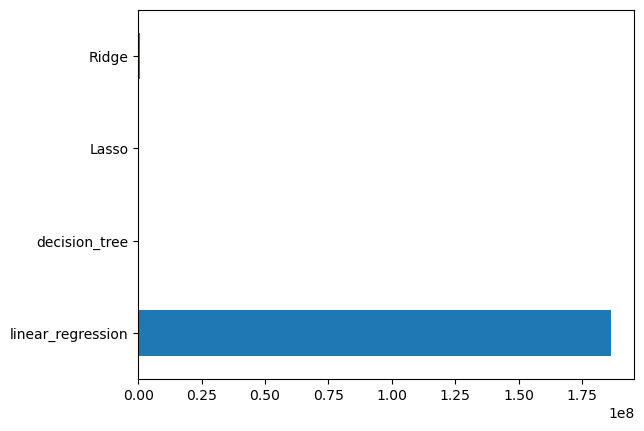

In [83]:
df_mse['mean'].plot.barh()

Such an anomaly for linear regression can be explained by an outlier in the data on fold 5.

In [84]:
df_rmse = pd.DataFrame.from_dict(data=rmse_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_rmse['mean'] = df_rmse[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_rmse

,fold_1,fold_2,fold_3,fold_4,fold_5,mean
linear_regression,518.07,353.55,371.96,464.66,30514.55,6444.56
decision_tree,439.17,499.13,493.72,554.76,670.81,531.52
Lasso,384.00,360.42,352.95,451.17,350.94,379.89
Ridge,460.01,352.16,371.89,466.41,1590.72,648.24


In [86]:
df_mae = pd.DataFrame.from_dict(data=mae_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mae['mean'] = df_mae[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mae

,fold_1,fold_2,fold_3,fold_4,fold_5,mean
linear_regression,241.48,152.51,121.12,106.73,4739.99,1072.37
decision_tree,106.31,134.85,134.38,115.53,112.86,120.79
Lasso,106.70,168.25,107.27,95.98,106.41,116.92
Ridge,211.99,151.86,121.39,106.25,336.29,185.55


In [94]:
%%time
result = pipe_lasso.predict(test[cols])
sample_submission = pd.DataFrame({'id':test.id,'sales':result}).set_index('id')
sample_submission

CPU times: user 76.8 ms, sys: 7.04 ms, total: 83.8 ms
Wall time: 72.2 ms


,sales
id,
3000991.00,4.70
3000917.00,62.54
3001151.00,1.21
3001145.00,10.72
3002601.00,7993.33
...,...
3029302.00,1.73
3029303.00,11.83
3029304.00,3793.45


Let's save the results to csv